## 📥 Load IMDB Dataset from Kaggle

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import kagglehub
import os

# Download the dataset dynamically (No need for manual downloading)
dataset_path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")

# Display dataset path
print("Dataset stored at:", dataset_path)

# Load the CSV file directly from the extracted dataset path
csv_file = os.path.join(dataset_path, "IMDB Dataset.csv")
df = pd.read_csv(csv_file)

# Display dataset info
df.head(), df.tail()


100%|██████████| 25.7M/25.7M [00:02<00:00, 11.8MB/s]

Extracting files...


Dataset stored at: /root/.cache/kagglehub/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/versions/1


(                                              review sentiment
 0  One of the other reviewers has mentioned that ...  positive
 1  A wonderful little production. <br /><br />The...  positive
 2  I thought this was a wonderful way to spend ti...  positive
 3  Basically there's a family where a little boy ...  negative
 4  Petter Mattei's "Love in the Time of Money" is...  positive,
                                                   review sentiment
 49995  I thought this movie did a down right good job...  positive
 49996  Bad plot, bad dialogue, bad acting, idiotic di...  negative
 49997  I am a Catholic taught in parochial elementary...  negative
 49998  I'm going to have to disagree with the previou...  negative
 49999  No one expects the Star Trek movies to be high...  negative)

## 📊 Data Insights & Preprocessing

In [2]:

# Get dataset overview
df.info()

# Summary statistics
df.describe()

# Check class distribution (bias)
df['sentiment'].value_counts()

# Check for missing values
df.isna().sum()

# Check for duplicate entries
df.duplicated().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


418

## 🧹 Text Preprocessing

In [3]:

import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download stopwords
nltk.download('stopwords')

# Remove stopwords function
#def remove_stopwords(text):
#   stop_words = stopwords.words('english')
#    words = text.split()
#   return ' '.join([word for word in words if word not in stop_words])

# Custom stopwords function
custom_stopwords = set(stopwords.words('english')) - {"not", "no", "nor"}  # Keep negations

def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word not in custom_stopwords])


# Normalize text function
def normalize_text(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub('\W', ' ', text)  # Remove special characters
    text = re.sub('\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Remove punctuation function
def remove_punctuation(text):
    return text.translate(str.maketrans('', '', string.punctuation))

# Stemming function
#ps = PorterStemmer()
#def stemming(text):
#    return ' '.join([ps.stem(word) for word in text.split()])

# Lemmatization function
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(word) for word in text.split()])


# Full text cleaning pipeline
def clean_text(text):
    text = normalize_text(text)
    text = remove_punctuation(text)
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

# Apply text preprocessing
df['cleaned_review'] = df['review'].apply(clean_text)
df[['review', 'cleaned_review']].head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,review,cleaned_review
0,One of the other reviewers has mentioned that ...,one reviewer mentioned watching 1 oz episode h...
1,A wonderful little production. <br /><br />The...,wonderful little production br br filming tech...
2,I thought this was a wonderful way to spend ti...,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",petter mattei love time money visually stunnin...


## 🔢 Label Encoding

In [4]:

from sklearn.preprocessing import OneHotEncoder

X = df["cleaned_review"]
y = df['sentiment']

# One-hot encode sentiment labels
encoder = OneHotEncoder()
y = encoder.fit_transform(np.asarray(y).reshape(-1,1)).toarray()


## 📏 Train-Test Split

In [5]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


## 🔠 Tokenization & Padding

In [6]:

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define tokenizer settings
vocab_size = 30000 # 10000 to 30000
max_length = 50
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# Apply padding
X_train = pad_sequences(X_train, maxlen=max_length, padding=padding_type, truncating=trunc_type)
X_test = pad_sequences(X_test, maxlen=max_length, padding=padding_type, truncating=trunc_type)


## 🤖 Model Building

In [7]:

from tensorflow.keras.models import Sequential
# Add Bidirectional GRU
from tensorflow.keras.layers import Embedding, Bidirectional, GRU, Dense, Dropout
# Add CNN
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping

# Define model architecture
def build_model():
    model = Sequential()

    # Embedding layer
    model.add(Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length))

    # CNN for feature extraction (Increased Filters, Reduced Kernel Size)
    model.add(Conv1D(256, kernel_size=3, activation='relu'))  # More filters, smaller kernel
    model.add(MaxPooling1D(pool_size=2))

    # Bidirectional GRU layers (Increased Units)
    model.add(Bidirectional(GRU(128, return_sequences=True)))
    model.add(Dropout(0.3))

    model.add(Bidirectional(GRU(64, return_sequences=True)))
    model.add(Dense(64, activation='relu'))  # Increased Dense Units
    model.add(Dropout(0.3))

    model.add(Bidirectional(GRU(64)))
    model.add(Dense(128, activation='relu'))  # Increased Dense Units
    model.add(Dropout(0.3))

    # Output Layer (Changed to `sigmoid` for Binary Classification)
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='val_loss', patience=3)

    return model, early_stopping

# Initialize model
model, early_stopping = build_model()

# Build model manually to resolve shape issue
model.build(input_shape=(None, max_length))
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 50, 64)              │       1,920,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (None, 48, 256)             │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 24, 256)             │         296,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 24, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 24, 128)             │         123,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 24, 64)              │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 24, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 128)                 │          49,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,464,321 (9.40 MB)

 Trainable params: 2,464,321 (9.40 MB)

 Non-trainable params: 0 (0.00 B)

## 🏋️ Training the Model

In [8]:

# Convert one-hot labels to binary labels
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

# Train the model
history = model.fit(X_train, y_train, epochs=15, batch_size=250, validation_split=0.1, callbacks=[early_stopping])

# Evaluate the model (No more shape error!)
score = model.evaluate(np.asarray(X_test), np.asarray(y_test))


Epoch 1/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.6506 - loss: 0.5809 - val_accuracy: 0.8375 - val_loss: 0.3703
Epoch 2/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.8996 - loss: 0.2535 - val_accuracy: 0.8367 - val_loss: 0.3883
Epoch 3/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9469 - loss: 0.1526 - val_accuracy: 0.8288 - val_loss: 0.4665
Epoch 4/15
144/144 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.9759 - loss: 0.0762 - val_accuracy: 0.8163 - val_loss: 0.5935
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.8213 - loss: 0.5682


## 📉 Model Evaluation

In [9]:

score = model.evaluate(np.asarray(X_test), np.asarray(y_test))


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8213 - loss: 0.5682


## 📊 Confusion Matrix & Performance Metrics

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


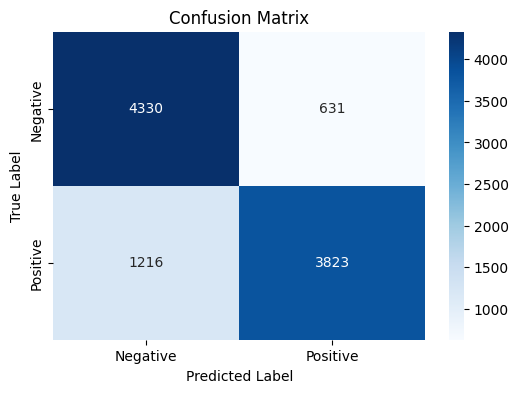

              precision    recall  f1-score   support

    Negative       0.78      0.87      0.82      4961
    Positive       0.86      0.76      0.81      5039

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.81     10000
weighted avg       0.82      0.82      0.81     10000



In [12]:

import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get model predictions
y_pred = model.predict(np.array(X_test))

# Convert predictions to class labels
y_pred_labels = (y_pred > 0.5).astype(int) # Convert probabilities to 0 or 1 based on threshold
# y_true_labels = np.argmax(y_test, axis=1)  # Remove this line - y_test is already binary

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_labels) # Use original y_test (binary labels)

# Plot confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(y_test, y_pred_labels, target_names=['Negative', 'Positive'])) # Use original y_test (binary labels)
